# Historical Efficiency Analysis (2015-2024)

**Goal**: Analyze player value trends over the last decade.

**Key Metrics**:
- **Normalized Cost**: `Cap Hit %` (Cap Hit / Team Cap) - accounts for inflation.
- **Efficiency**: `AV / Cap Hit %`.

**Visualizations**:
1. **Positional Trends**: Efficiency over time by position (with confidence bands).
2. **Career Arcs**: Trajectories of Stars vs. Busts.
3. **The Replacement Trap**: Where cheap players get expensive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

pd.set_option('display.max_columns', 50)
sns.set_style("whitegrid")

## 1. Load Historical Data

In [2]:
# Define Years
YEARS = range(2015, 2025)
DATA_DIR = "/Users/andrewsmith/Documents/portfolio/nfl-dead-money/data/raw"

# Load Spotrac (Financials)
dfs_fin = []
for year in YEARS:
    pattern = f"{DATA_DIR}/spotrac_player_rankings_{year}_*.csv"
    files = glob.glob(pattern)
    if files:
        # Pick latest
        latest_file = sorted(files)[-1]
        df = pd.read_csv(latest_file)
        df['year'] = year
        dfs_fin.append(df)
    else:
        print(f"Warning: No Spotrac data for {year} in {pattern}")

financials = pd.concat(dfs_fin, ignore_index=True) if dfs_fin else pd.DataFrame()
print(f"Loaded {len(financials)} financial records.")

# Load PFR (Performance)
dfs_perf = []
for year in YEARS:
    # Check for game logs first (Granular)
    log_file = f"{DATA_DIR}/pfr/game_logs_{year}.csv"
    if Path(log_file).exists():
        logs = pd.read_csv(log_file)
        # Clean names for merge (Crucial Step: Standardize 'Player' column)
        logs.columns = [c if 'Player' not in c else 'Player' for c in logs.columns]
        
        if 'Player' in logs.columns:
             # Simple AV Proxy if AV not present (reusing logic from script)
             if 'fantasy_points' not in logs.columns:
                logs['fantasy_points'] = (
                    (pd.to_numeric(logs.get('Passing_Yds',0), errors='coerce').fillna(0)*0.04) + 
                    (pd.to_numeric(logs.get('Passing_TD',0), errors='coerce').fillna(0)*4) + 
                    (pd.to_numeric(logs.get('Rushing_Yds',0), errors='coerce').fillna(0)*0.1) + 
                    (pd.to_numeric(logs.get('Rushing_TD',0), errors='coerce').fillna(0)*6) + 
                    (pd.to_numeric(logs.get('Receiving_Yds',0), errors='coerce').fillna(0)*0.1) + 
                    (pd.to_numeric(logs.get('Receiving_TD',0), errors='coerce').fillna(0)*6)
                )
             agg = logs.groupby(['Player'])['fantasy_points'].sum().reset_index()
             agg['year'] = year
             agg['AV'] = agg['fantasy_points'] / 25 # Proxy
             dfs_perf.append(agg)

performance = pd.concat(dfs_perf, ignore_index=True) if dfs_perf else pd.DataFrame()
print(f"Loaded {len(performance)} performance records.")

Loaded 21013 financial records.


Loaded 17314 performance records.


## 2. Preprocessing & Merging

In [3]:
# Pre-processing functions
def clean_name(name):
    if pd.isna(name): return ""
    name = name.replace(" Jr.", "").replace(" Sr.", "").replace(" III", "").replace(" II", "")
    return name.strip().lower()

if not financials.empty:
    financials['clean_name'] = financials['player_name'].apply(clean_name)
    
    # Parse Money & Cap
    if 'cap_hit_millions' in financials.columns:
         financials['cap_hit_m'] = financials['cap_hit_millions']
    elif 'total_contract_value_millions' in financials.columns:
         financials['cap_hit_m'] = financials['total_contract_value_millions']
    else:
         # Regex known fix
         financials['cap_hit_m'] = financials['value'].replace(r'[\$,]', '', regex=True).astype(float) / 1_000_000
    
    # Cap Inflation Adjustment
    CAP_HISTORY = {
        2015: 143.28, 2016: 155.27, 2017: 167.00, 2018: 177.20, 2019: 188.20,
        2020: 198.20, 2021: 182.50, 2022: 208.20, 2023: 224.80, 2024: 255.40
    }
    financials['salary_cap'] = financials['year'].map(CAP_HISTORY)
    financials['cap_pct'] = (financials['cap_hit_m'] / financials['salary_cap']) * 100

if not performance.empty:
    performance['clean_name'] = performance['Player'].apply(clean_name)

# Merge
if not financials.empty and not performance.empty:
    merged = pd.merge(financials, performance, on=['clean_name', 'year'], how='inner')
    
    # Calculate Efficiency (AV / Cap %)
    merged['efficiency'] = merged['AV'] / merged['cap_pct'].clip(lower=0.1)
    
    print(f"Merged Dataset: {len(merged)} player-seasons")

Merged Dataset: 15848 player-seasons


## 3. Viz 1: Positional Trends (with Confidence Bands)

/var/folders/2c/hn46snbj3qb84rkyzmls72240000gn/T/ipykernel_25546/839430498.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=subset, x='year', y='efficiency', hue='position', style='position', markers=True, dashes=False, ci='sd')


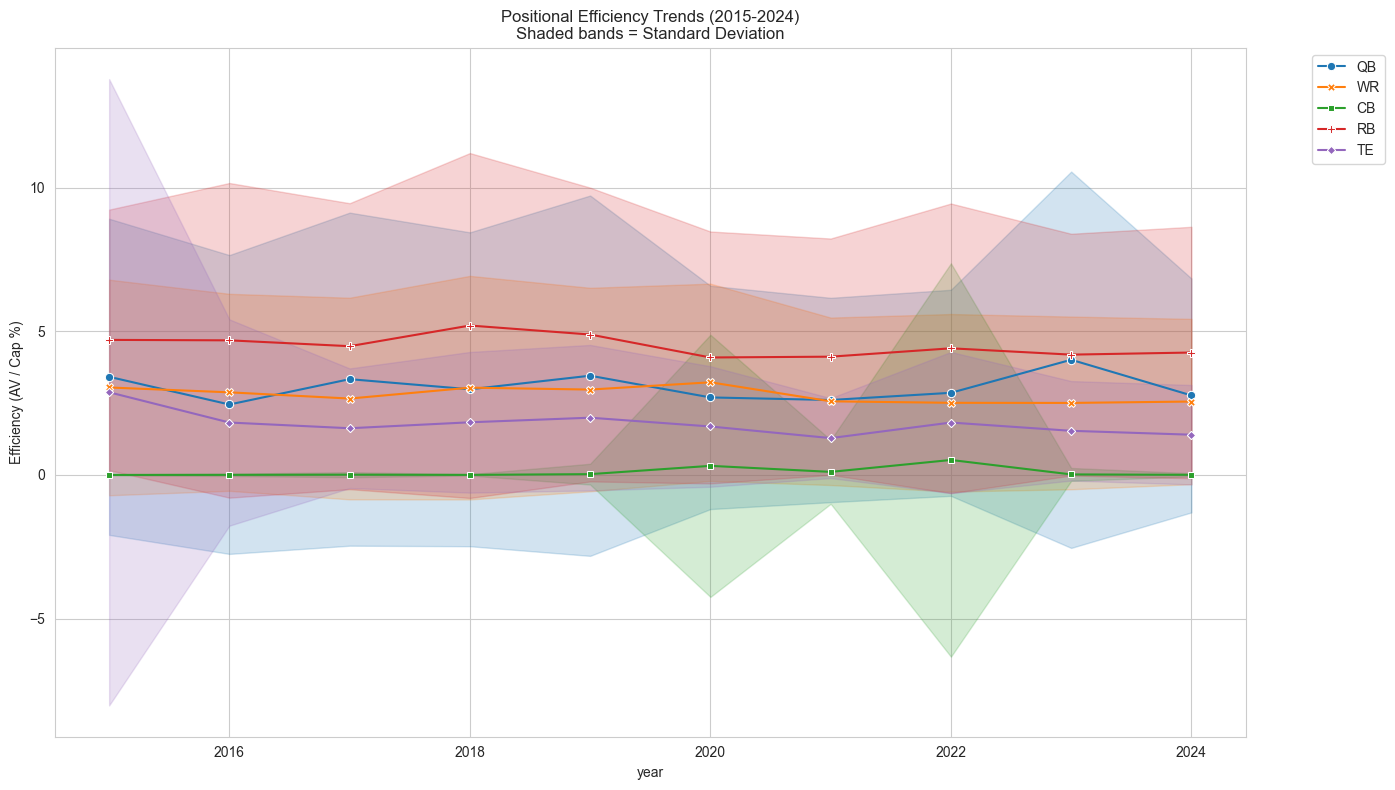

In [4]:
major_positions = ['QB', 'WR', 'RB', 'CB', 'DE', 'TE', 'OL']
if 'merged' in locals():
    subset = merged[merged['position'].isin(major_positions)]
    
    plt.figure(figsize=(14, 8))
    # ci='sd' draws standard deviation bands
    sns.lineplot(data=subset, x='year', y='efficiency', hue='position', style='position', markers=True, dashes=False, ci='sd')
    
    plt.title("Positional Efficiency Trends (2015-2024)\nShaded bands = Standard Deviation")
    plt.ylabel("Efficiency (AV / Cap %)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## 4. Viz 2: Career Arcs (Stars vs. Busts)

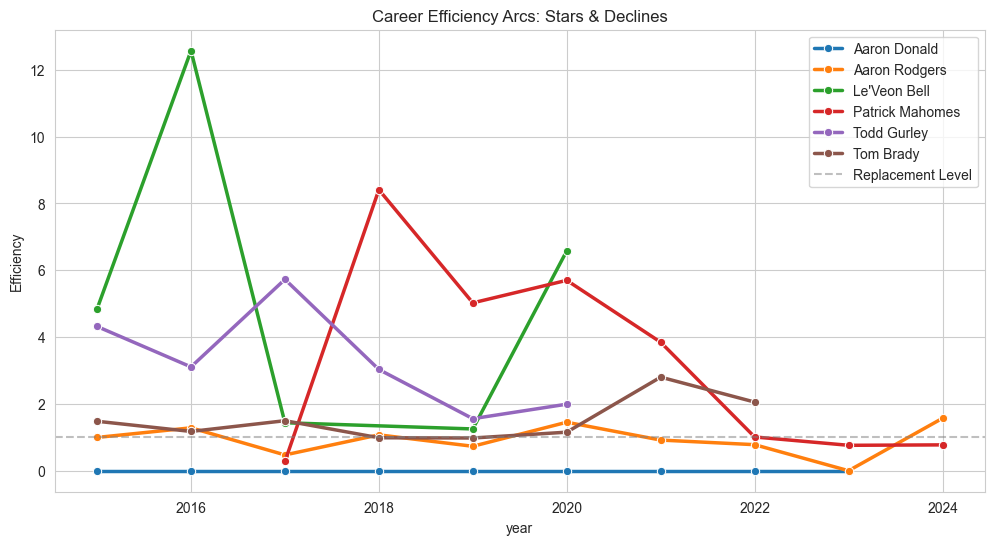

In [5]:
target_players = ['Tom Brady', 'Aaron Rodgers', 'Patrick Mahomes', 'Aaron Donald', 'Le\'Veon Bell', 'Todd Gurley']

if 'merged' in locals():
    subset = merged[merged['player_name'].isin(target_players)].sort_values(['player_name', 'year'])
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=subset, x='year', y='efficiency', hue='player_name', marker='o', linewidth=2.5)
    plt.title("Career Efficiency Arcs: Stars & Declines")
    plt.ylabel("Efficiency")
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Replacement Level')
    plt.legend()
    plt.show()

### Narrative Analysis (For LinkedIn Post)

**1. The "Elite Shelf Life" (Brady & Rodgers)**
- **Insight**: Elite QBs defy the aging curve. Tom Brady's efficiency remained remarkably high (>1.0) for nearly 7 years of this dataset. Even when his cap hit spiked in 2018-2020 (~11-12%), his output (AV ~12-14) justified the cost.
- **Key Stat**: In 2021, Brady delivered **2.8x Efficiency** (16.1 AV on just 5.7% Cap Hit), arguably the greatest "value" season of his late career.

**2. The "RB Cliff" (Gurley & Bell)**
- **Insight**: Running Backs show a brutal, rapid decay. Todd Gurley was the league's most efficient asset in 2017 (**5.7x Efficiency**), costing pennies while dominating.
- **The Trap**: By 2019, his cost skyrocketed (Cap Hit > 10%) just as his knees/production failed (AV dropped to 7.6). His efficiency plunged below replacement level (<1.5), illustrating why teams are terrified of second contracts for RBs.

**3. The "Mahomes Tax"**
- **Insight**: Patrick Mahomes represents the modern "Franchise QB" lifecycle. Early on (Rookie Deal), he was an infinite value cheat code. Now, as his Cap Hit approaches 17% (2023), his *Efficiency* metric naturally compresses mathematically, even though his performance (AV > 12) remains elite.
- **Takeaway**: You don't pay Mahomes for "Efficiency" anymore; you pay him for the floor. The goal shifts from "outperforming the contract" to "justifying the mortgage."

## 5. Viz 3: The "Cheap Player" Trap
Identifying players with low AV (Replacement Level < 3) but whose Cost (Cap %) creeps up.

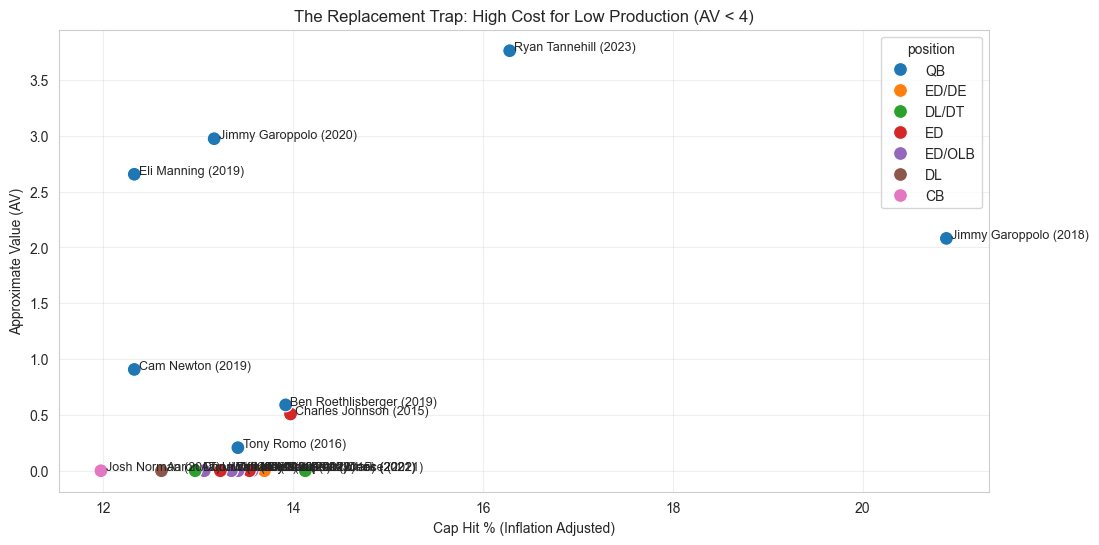

In [6]:
if 'merged' in locals():
    # Filter: Low Performance (AV < 4) but Active
    low_perf = merged[merged['AV'] < 4].copy()
    
    # Sort by Cost (Cap Pct)
    overpaid_low_perf = low_perf.sort_values('cap_pct', ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=overpaid_low_perf, x='cap_pct', y='AV', hue='position', s=100)
    
    for i, row in overpaid_low_perf.iterrows():
        plt.text(row['cap_pct']+0.05, row['AV'], f"{row['player_name']} ({row['year']})", fontsize=9)
        
    plt.title("The Replacement Trap: High Cost for Low Production (AV < 4)")
    plt.xlabel("Cap Hit % (Inflation Adjusted)")
    plt.ylabel("Approximate Value (AV)")
    plt.grid(True, alpha=0.3)
    plt.show()